In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os
import copy
import glob
import numpy as np
import pandas as pd
import time
import sys

from astropy import units as u
from astropy.table import Table, join, hstack
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.backends.backend_pdf import PdfPages


cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

In [3]:
from marvin import config
from marvin.tools import Maps, Cube, ModelCube
import marvin.utils.plot.map as mapplot
from marvin.tools.image import Image
from marvin.utils.general import Cutout

config.access = 'collab'
config.mode = 'remote'
config.login()
config.setRelease('MPL-11')

[INFO]: No release version set. Setting default to DR15
[WARNING]: path /Users/adiamond/physics/linux-lab/data/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/adiamond/physics/linux-lab/data/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: path /Users/adiamond/physics/linux-lab/data/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from marvin.utils.general import get_drpall_table
drpall = get_drpall_table()
print(len(drpall))

# Get only manga galaxies 
manga_drp = drpall[drpall['srvymode'] == 'MaNGA dither']
print(len(manga_drp))

# Find all MaNGA galaxy data cubes
cube_bools = (manga_drp['mngtarg1'] != 0) | (manga_drp['mngtarg3'] != 0)
drp = manga_drp[cube_bools]
print('Number of galaxies', len(drp))


### Get NSA data in order to get concentration -- 
nsa = Table.read('MPL11/1-nsa_v1_0_1.fits',hdu=1)
[nsa.rename_column(n_col, ma_col) for n_col, ma_col in zip(['IAUNAME','NSAID'],['nsa_iauname', 'nsa_nsaid'])]

nsa_data = nsa['nsa_iauname', 'nsa_nsaid', 'ELPETRO_TH90_R', 'ELPETRO_TH50_R']


## drp and nsa data
drp_nsa = join(drp, nsa_data, keys=['nsa_iauname','nsa_nsaid'], join_type='left')

11273
10483
Number of galaxies 10450


In [6]:
# define edge-on galaxy cutoff of b/a ratio < 0.3
edge = drp_nsa['nsa_sersic_ba'] < 0.3

# define late type 
late = (drp_nsa['ELPETRO_TH90_R'] / drp_nsa['ELPETRO_TH50_R']) < 2.6

# Define table with late-type edge on galaxies grouped by manga ID
drp_edge_late = drp_nsa[edge & late].group_by('mangaid')

print('Total number of late-type edge-on galaxy observations:        ', len(drp_edge_late))
print('Total number of unique late-type edge-on galaxy observations: ', len(drp_edge_late.groups))


Total number of late-type edge-on galaxy observations:         927
Total number of unique late-type edge-on galaxy observations:  919


In [7]:
test = np.sort(drp_edge_late['plateifu'])
#print(test[0:10])
with open('plate-ifu-mpl11.txt', 'w') as f:
    for i in range(0,len(test)):
        print(test[i], file=f)

# Making the maps

In [8]:
def getProj(size, ba, theta, spaxel_size, arcsec2kpc):
    
    # array that coorsponds to x and y spaxel coordinates vector
    xy_vector = np.arange(size)-np.median(range(size))    
    xpos, ypos = np.meshgrid(xy_vector, xy_vector)

    # compute the on-sky x and y coordiates defined by the major axis
    inc = np.arccos(ba)
    trad = np.radians(theta - 90)
    xproj = xpos * np.cos(trad) + ypos * np.sin(trad)
    yproj = xpos * np.sin(trad) * (-1.) + ypos * np.cos(trad)
    zproj = yproj / np.sin(inc) * np.cos(inc)

    # calculate the radius of each pixel in the plane of the disk [units: pixels]
    pixel_radius = np.sqrt(xproj ** 2 + (yproj / ba) ** 2)
    radkpc = pixel_radius * arcsec2kpc.value * spaxel_size    # conversion between pixel size and kpc

    # compute values along the x and y axis of the disk and the z axis above the disk
    xproj_kpc = xproj * arcsec2kpc.value * spaxel_size
    yproj_kpc = yproj / ba * arcsec2kpc.value * spaxel_size
    zproj_kpc = zproj / ba * arcsec2kpc.value * spaxel_size

    # making on sky projection maps [unit: kpc]
    radkpc_map, xproj_kpc_map, yproj_kpc_map, zproj_kpc_map = np.zeros([4, size, size])
    for j in range(0, size):
        for k in range(0, size):
            radkpc_map[j, k] = radkpc[j, k]
            yproj_kpc_map[j, k] = yproj_kpc[j, k] 
            zproj_kpc_map[j, k] = zproj_kpc[j, k]   

    return (xproj_kpc,  yproj_kpc, zproj_kpc, radkpc_map)



def stallMessage(map_str):
    print('                Stall for {}'.format(map_str))
    time.sleep(5)  
    
# ----------------------------------------------------- Image functions

def stripOverlay(marvinIm):
    h = float(marvinIm.header['HEIGHT'])
    scale = float(marvinIm.header['SCALE'])
    
    marvinIm.get_new_cutout(h,h,scale=scale)


def bw_im(image):
    return image.convert("L")


def im_arr(image):
    return np.array(image,'f')


def contourArray(image, q =[.38, .75, .95]):
    bw = bw_im(image)
    
    array = im_arr(bw)
    p50 = np.quantile(array, .82)
    array[array <=p50] = 0 
    
    levels = np.quantile(array[array>0], q)
    
    return (array, levels)

In [15]:
total = len(drp_edge_late)
print(total)
drp_edge_late.sort(['plate','ifudsgn'])
drp_edge_late

927


<Table length=927>
plate ifudsgn   plateifu  ... ELPETRO_TH90_R ELPETRO_TH50_R
int64 bytes32   bytes32   ...    float32        float32    
----- ------- ----------- ... -------------- --------------
 7443   12704  7443-12704 ...      36.768234      18.390207
 7495   12702  7495-12702 ...      28.174982      12.336762
 7495    3702   7495-3702 ...      10.944376      4.6867857
 7495    3703   7495-3703 ...      10.901109       5.026749
 7495    6104   7495-6104 ...      14.646263      6.3335857
 7815    6101   7815-6101 ...      13.228344       6.083876
 7957    6102   7957-6102 ...      12.679818       5.618904
 7958   12702  7958-12702 ...      15.249853       8.084469
 7958   12703  7958-12703 ...      14.101409       6.251291
 7958   12704  7958-12704 ...      27.125198      14.637137
  ...     ...         ... ...            ...            ...
12675    3703  12675-3703 ...      11.470007      4.5770555
12685   12703 12685-12703 ...      21.976559       9.664472
12696    9102  12696-9102 ...      10.090676      4.1450067
12700   12701 12700-12701 ...      25.702269      11.349792
12700   12702 12700-12702 ...      20.693172      10.130387
12700    6103  12700-6103 ...       9.524976      3.9608095
12700    9101  12700-9101 ...       8.198934       4.402073
12772   12703 12772-12703 ...      33.193485      14.866675
12772    3703  12772-3703 ...      18.428318      7.5097723
12772    9101  12772-9101 ...      14.392485       6.958997

In [10]:
bad = np.zeros(total, dtype=object)

In [ ]:
filename = 'mpl_11_FinalClassification.pdf'

t_gal= []

start = time.time()
with PdfPages(filename) as pdf:
    for i in range(0,42):
        time_gal = time.time()

        ### getting drp parameters
        drpDat = drp_edge_late[i]

        plateifu = drpDat['plateifu']
        print('({}) {}'.format(i+1, plateifu))

        ### getting data from marvin
        try:
            maps = Maps(plateifu=plateifu, bintype='HYB10', drpall=drpDat)
            print('MAP   ', u'\u2713')


            ### getting drp parameters
            z, ba, theta, re_arcsec = drpDat['nsa_z', 'nsa_sersic_ba', 'nsa_sersic_phi', 'nsa_sersic_th50']

            # conversion factor -- kpc/arcsec
            arcsec2kpc = (1/cosmo.arcsec_per_kpc_proper(z))


            # ------------------------------------------------- Getting maps

            try:
                ha = maps.emline_gflux_ha_6564                  # Halpha flux map
            except:
                stallMessage('Halpha flux')

                ha = maps.emline_gflux_ha_6564

            print('FLUX  ', u'\u2713')


            ### Set Halpha signal to noise cut   
            try:
                low_snr = ha.snr < 3                            # Halpha flux s/n cut >3
            except:
                stallMessage('snr cut')

                low_snr = ha.snr < 3 
                ha.mask = ha.mask | low_snr                     # update mask

            print('SNR   ', u'\u2713')


            ### Halpha velocity map
            try:
                haVel = maps.emline_gvel_ha_6564                # Halpha velocity map
            except:
                stallMessage('Halpha vel')
                haVel = maps.emline_gvel_ha_6564

            print('VEL   ', u'\u2713')


            ### Halpha vel_mask    
            try:
                haVel.mask = haVel.mask | low_snr               # Halpha vel mask
            except:
                stallMessage('Halpha vel mask')
                haVel.mask = haVel.mask | low_snr             

            print('VEL MSK', u'\u2713')


            # ------------------------------------------------- Spatial properties of the maps 

            wcs = maps.wcs.dropaxis(2)
            spaxel_size = wcs.pixel_scale_matrix[1,1]*3600
            size = ha.shape[0]


            # ------------------------------------------------- Making asymmetry map

            xproj_kpc,  yproj_kpc, zproj_kpc, radkpc_map = getProj(size, ba, theta, spaxel_size, arcsec2kpc)


            # making copies of maps 
            flip_flux = ha.copy()
            flip_vel = haVel.copy()
            major_axis = np.zeros(ha.shape, dtype=bool)     

            for m in range(0, size):
                for n in range(0, size):
                    dist = np.sqrt((xproj_kpc - xproj_kpc[m, n]) ** 2 + (yproj_kpc + yproj_kpc[m, n]) ** 2)
                    test = (dist == np.min(dist))

                    flip_flux.value[m, n] = ha.value[test]
                    flip_flux.mask[m, n] = ha.mask[test]
                    flip_flux.snr[m, n] = ha.snr[test]

                    flip_vel.value[m, n] = haVel.value[test]; 
                    flip_vel.mask[m,n] = haVel.mask[test]

                    if (np.ravel(np.where(test == True)) == [m,n]).all():
                        major_axis[m, n] = True

            ### setting assymetry map values 
            asym = haVel.copy()
            asym.value[:,:] = haVel.value - flip_vel.value
            asym.mask = haVel.mask | flip_vel.mask

            # making mask to cutout central disk
            re_kpc = (1.5 * re_arcsec) * arcsec2kpc.value # Effective radius = 1.5 * nsa_sersic_th50
            cen = abs(radkpc_map) < (re_kpc)
        #     perc65 = np.percentile(abs(asym.value.ravel()),65)
        #     out = (abs(asym.value) < perc65)


            # ------------------------------------------------- Getting image cutout data

            ### original cutout with hexagon and sky footprints overlayed 

            im = Image(plateifu, download=False)
            im_wcs = im.wcs

            ### data for image plot
            im_data = im.data

            # get xlimits and ylimits to match maps
            ra_lim, dec_lim = wcs.pixel_to_world_values([0, size-1], [0, size-1])
            [xmin,xmax], [ymin,ymax] = im.wcs.world_to_pixel_values(ra_lim, dec_lim)
            scale = float(im.header['SCALE'])
            big = scale * 350
            xl = (xmin-big,xmax+big); yl = (ymin-big,ymax+big)


            ### image contours

            stripOverlay(im)                          # new cutout for image plot contours

            ct_array, lvls = contourArray(im.data)    # contour array and levels

            # Getting x and y position arrays for map contour
            xy_vim_world = im.wcs.array_index_to_world(np.arange(0, ct_array.shape[0]), np.arange(0, ct_array.shape[0]))
            xv_im_p, yv_im_p = wcs.world_to_pixel(xy_vim_world)
            XX, YY = np.meshgrid(xv_im_p, yv_im_p)

            # ifu footprint hexagon
            hex_bundle = wcs.world_to_pixel_values(im.bundle.hexagon)


    #         # image array for image contour
    #         ct_array = np.array(im.data.convert("L"),'f') # convert to black and white image, then to array 
            ### defining quantiles for contour
    #         q = [.94, .99, 1]
    #         levels = np.quantile(ct_array, q)


            # ------------------------------------------------- Plotting

            ### making Figure
            fig = plt.figure(constrained_layout=False, figsize=(30,10))
            spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig,  hspace=0.2)


            ### plot image
            ax1 = fig.add_subplot(spec[0,0], projection=im_wcs)
            ax1.imshow(im_data)
            ax1.contour(ct_array, levels=lvls, colors='w', origin='upper', zorder=15, linewidths=1, linestyles='dashed')

            # set title
            ax1.set_title(plateifu)
            # set xlimits and ylimits to match maps
            ax1.set(xlim=xl, ylim=yl)


            ### 
            map_keys = ['spx_snr', 'stellar_vel', 'emline_gsigma_ha_6564']
            r1_titles = ['r-band snr', 'stellar vel', 'vel disp']

            print("Getting new maps")
            for ii, (m_type, t) in enumerate(zip(map_keys, r1_titles)):

                loc = ii+1
                ax = fig.add_subplot(spec[0,loc])

                try:
                    new_map = maps[m_type]
                except:
                    stallMessage(m_type)
                    new_map = maps[m_type]

                mask = new_map.mask 
                new_map.plot(fig=fig, ax=ax, mask=mask, title=t, return_cb=False, sky_coords=False)

                ax.add_patch(patch.Polygon(hex_bundle, ec='magenta', fill=False, lw=2, zorder=11))
                ax.contour(XX, np.flip(YY,0), ct_array, levels=lvls, colors='w', origin='upper', zorder=20, linewidths=1, linestyles='dashed')
                ax.set(xlim=(0, size-1), ylim=(0,size-1))


            ###    
            r2_maps = [haVel, flip_vel, asym, asym]
            r2_mask = [major_axis, np.zeros([size,size], dtype=bool), np.zeros([size,size], dtype=bool), cen]
            r2_titles = ['Ha vel 6564', 'Ha vel 6564 Flip', 'Asymmetry','Asymmetry center cut']
            cbrange= np.percentile(haVel.value, [10, 90])

            for r2, (m_type, t) in enumerate(zip(r2_maps, r2_titles)):

                loc = r2
                ax = fig.add_subplot(spec[1,loc])

                mask = r2_mask[r2] | m_type.mask
                pl = m_type.plot(fig=fig, ax=ax, mask=mask, title=t, return_cb=True, sky_coords=False, cbrange=cbrange)
                if r2<3:
                    pl[2].remove()

                ax.add_patch(patch.Polygon(hex_bundle, ec='magenta', fill=False, lw=2, zorder=11))
                cont = ax.contour(XX, np.flip(YY,0), ct_array, levels=lvls, colors='w', origin='upper', zorder=20, linewidths=1, linestyles='dashed')#, 
                          #extent=[0, size-1, 0, size-1])
                ax.set(xlim=(0, size-1), ylim=(0,size-1))


            pdf.savefig(facecolor=fig.get_facecolor(), edgecolor='none')
            plt.close()
            t_gal.append(np.round(time.time()-time_gal,2))
            print('gal took', np.round(time.time()-time_gal,2), 'seconds \n')
        except:
            print('\t\t\t\t BAD -- ', "Error on line {}".format(sys.exc_info()[-1].tb_lineno))
            bad[i] = plateifu
            time.sleep(5)
        
        
print('IT TOOK', np.round(time.time()-start,2), 'SECONDS TOTAL')



(1) 7443-12704
MAP    ✓
FLUX   ✓
SNR    ✓
VEL    ✓
VEL MSK ✓
Getting new maps
gal took 10.24 seconds 

(2) 7495-12702
MAP    ✓
FLUX   ✓
SNR    ✓
VEL    ✓
VEL MSK ✓
Getting new maps
gal took 9.47 seconds 

(3) 7495-3702
MAP    ✓
FLUX   ✓
SNR    ✓
VEL    ✓
VEL MSK ✓
Getting new maps
gal took 8.67 seconds 

(4) 7495-3703
MAP    ✓
FLUX   ✓
SNR    ✓
VEL    ✓
VEL MSK ✓
Getting new maps
gal took 8.15 seconds 

(5) 7495-6104
MAP    ✓
FLUX   ✓
SNR    ✓
VEL    ✓
VEL MSK ✓
Getting new maps
gal took 8.49 seconds 

(6) 7815-6101


In [182]:
np.linspace(.2, 1.0, 3)

array([0.2, 0.6, 1. ])

(0) 12514-3704
['SECONDARY_v1_1_0', 'SECONDARY_COM2', 'SECONDARY_v1_2_0']
(1) 10843-12704
['PRIMARY_v1_1_0', 'PRIMARY_COM2', 'PRIMARY_v1_2_0']
(2) 11866-9101
['PRIMARY_v1_1_0', 'PRIMARY_COM2', 'PRIMARY_v1_2_0']
(3) 10843-12703
['SECONDARY_v1_1_0', 'SECONDARY_v1_2_0']
(4) 12071-9101
['COLOR_ENHANCED_v1_1_0', 'COLOR_ENHANCED_COM2', 'COLOR_ENHANCED_v1_2_0']
(5) 12696-9102
['SECONDARY_v1_1_0', 'SECONDARY_v1_2_0']
(6) 8078-12704
['SECONDARY_v1_1_0', 'SECONDARY_COM2', 'SECONDARY_v1_2_0']
(7) 11836-1901
['COLOR_ENHANCED_v1_2_0']
(8) 12685-12703
['PRIMARY_v1_1_0', 'PRIMARY_COM2', 'PRIMARY_v1_2_0']
(9) 7815-6101
['PRIMARY_COM2']
(10) 7972-3701
['PRIMARY_v1_1_0']
(11) 8618-12701
['COLOR_ENHANCED_v1_1_0', 'PRIMARY_v1_2_0']
(12) 7975-3701
['SECONDARY_v1_1_0', 'SECONDARY_v1_2_0']
(13) 8619-12704
[]
(14) 7975-12703
['PRIMARY_v1_1_0', 'COLOR_ENHANCED_COM2', 'PRIMARY_v1_2_0']
(15) 7975-9102
['PRIMARY_v1_1_0', 'PRIMARY_v1_2_0']
(16) 7979-12705
['COLOR_ENHANCED_v1_1_0', 'COLOR_ENHANCED_COM2', 'COLOR_ENH

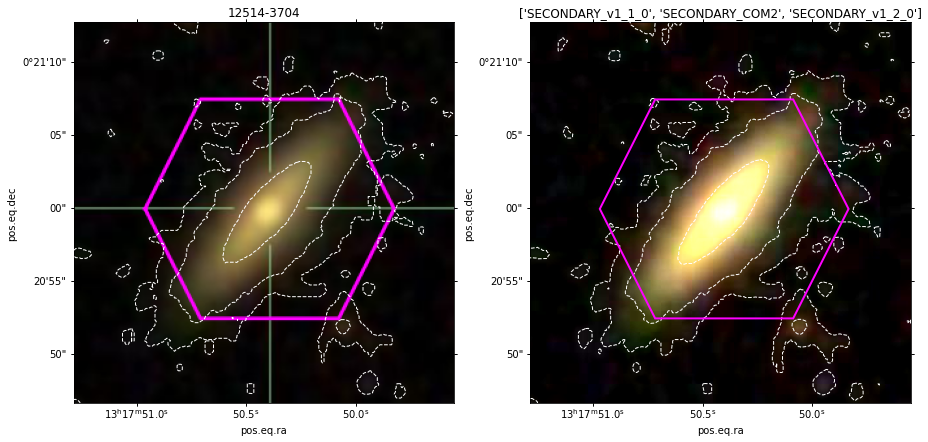

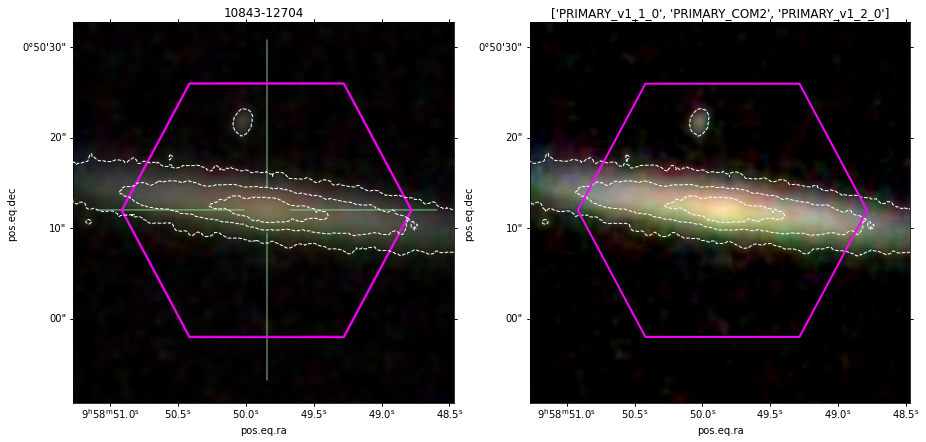

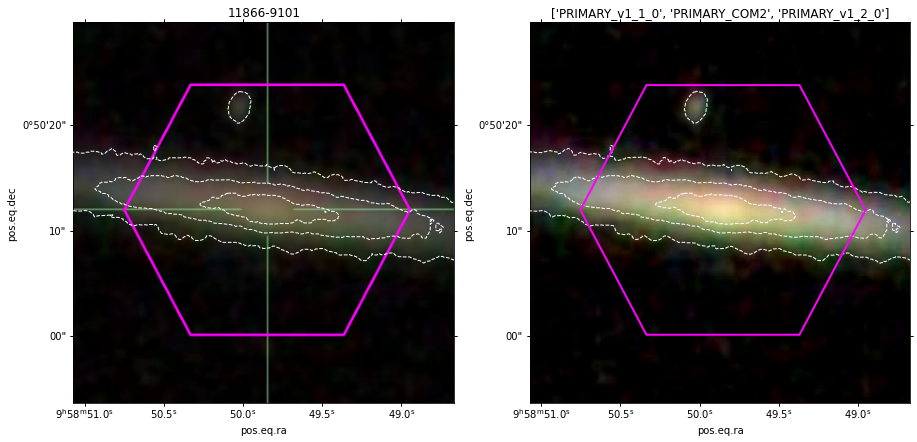

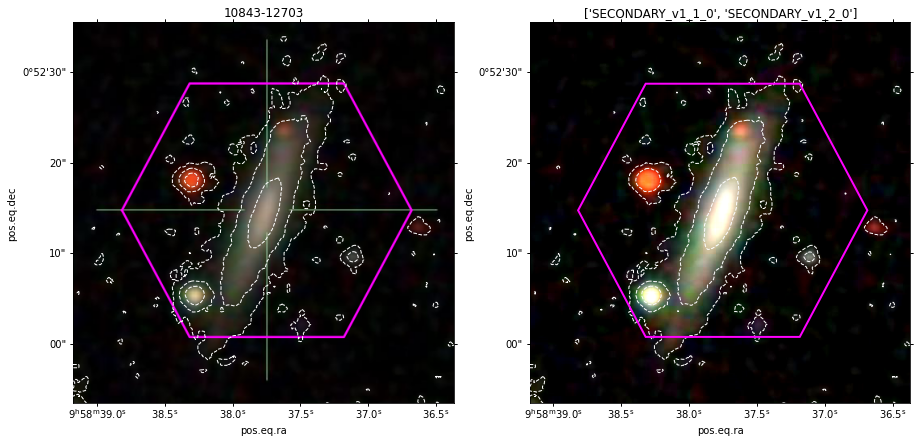

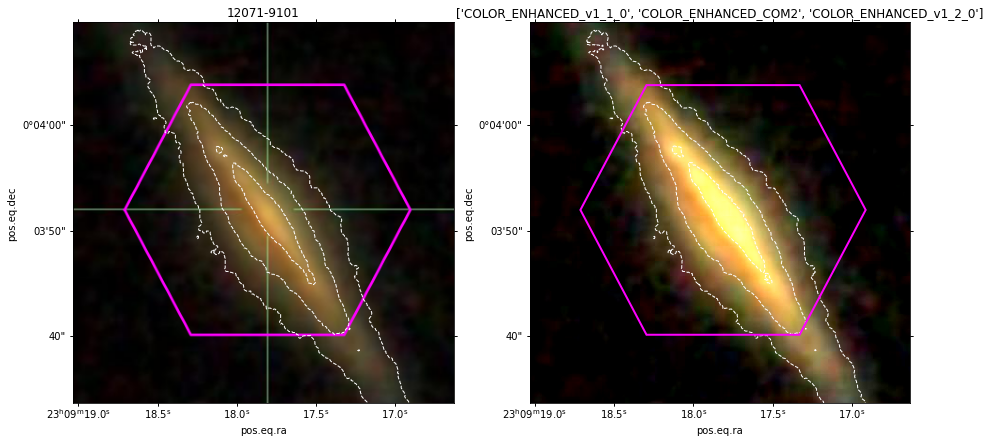

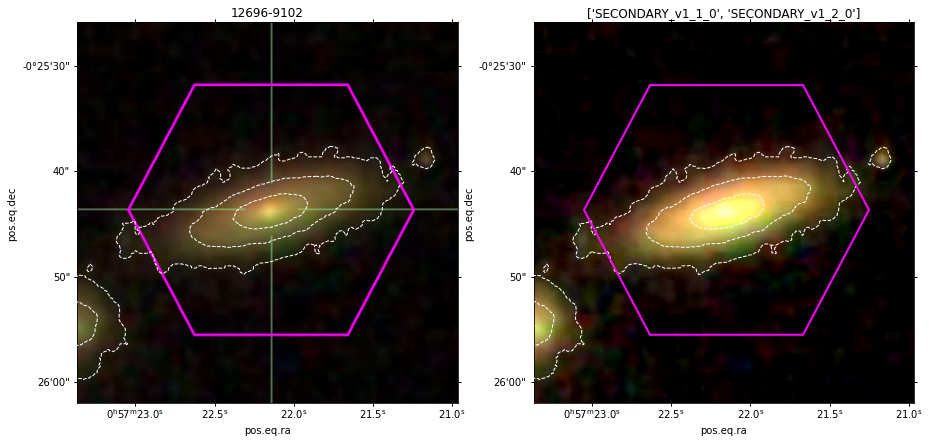

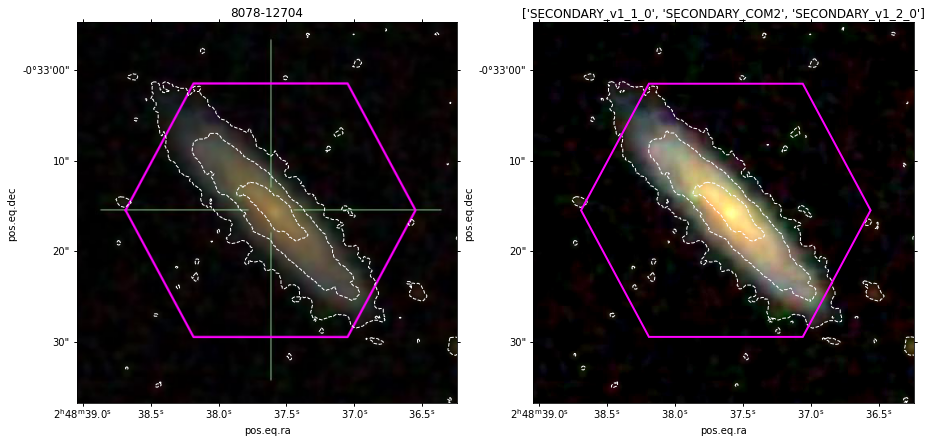

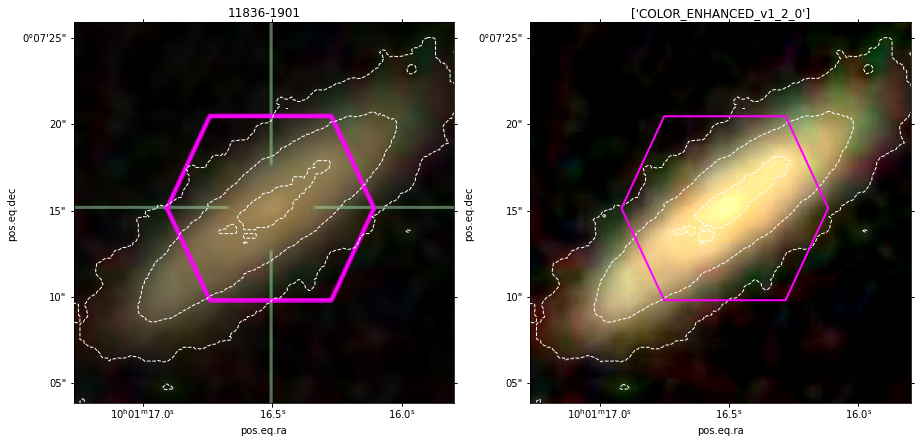

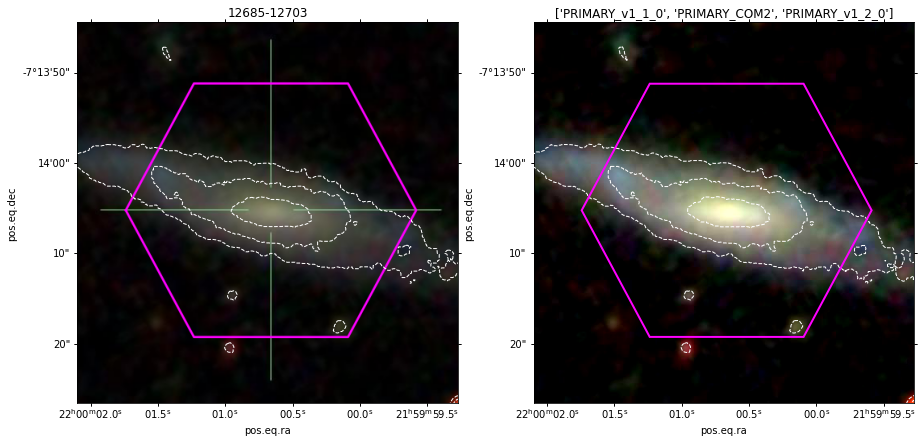

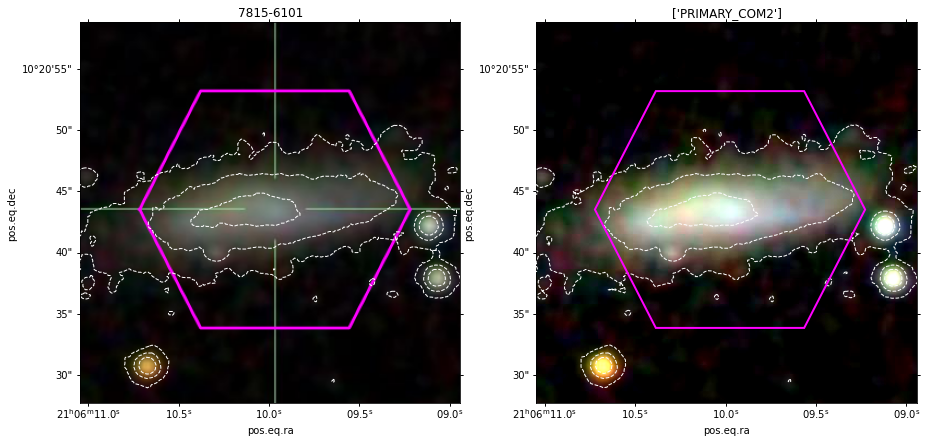

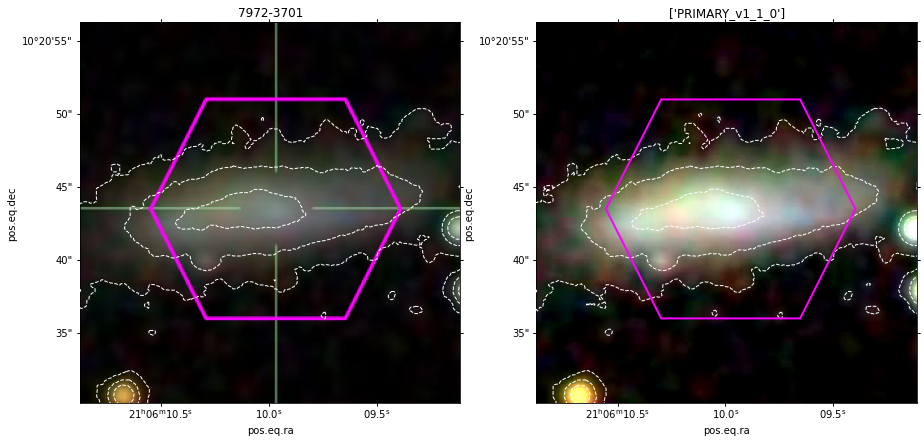

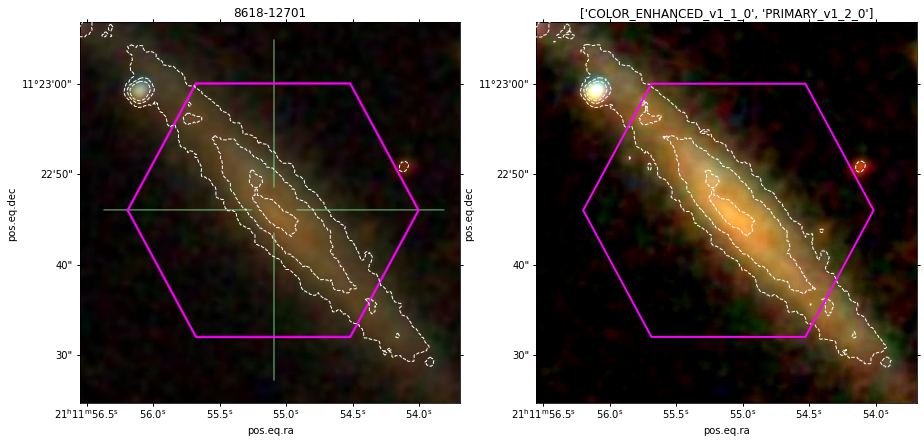

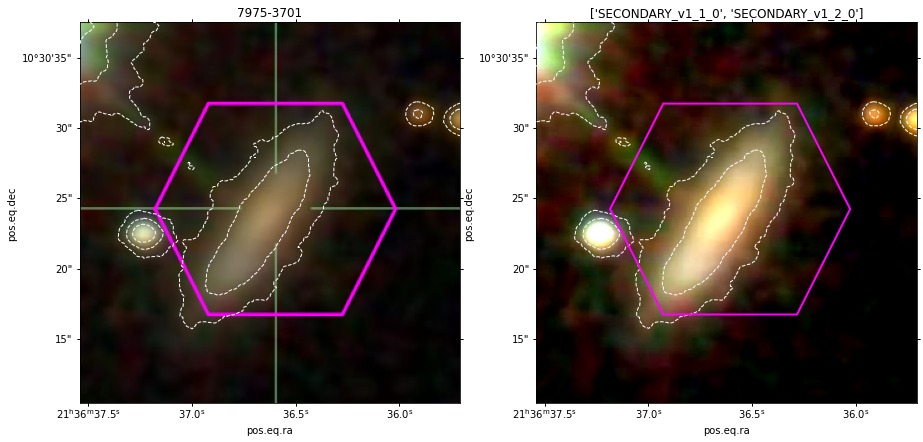

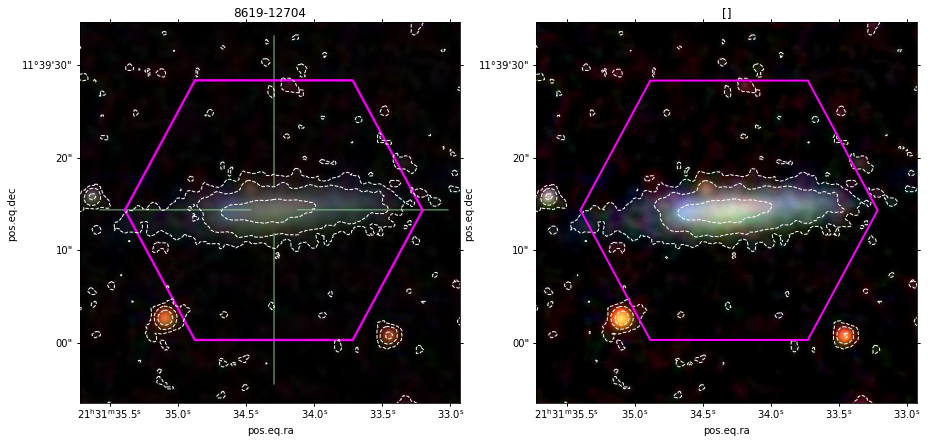

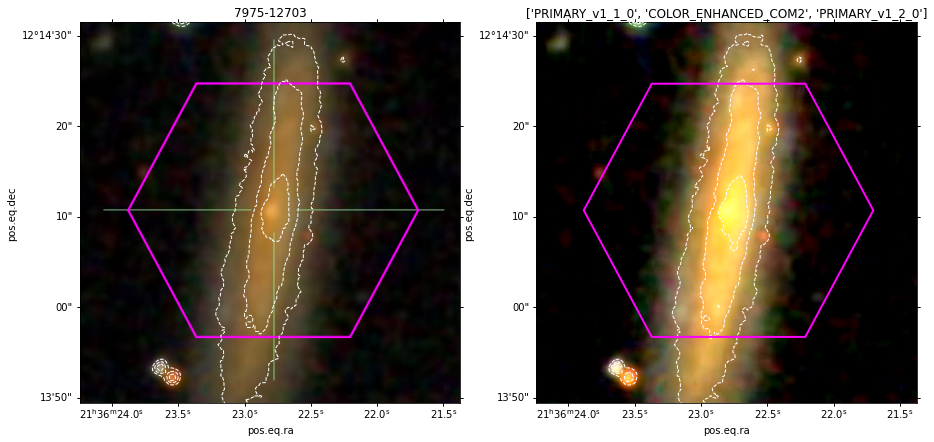

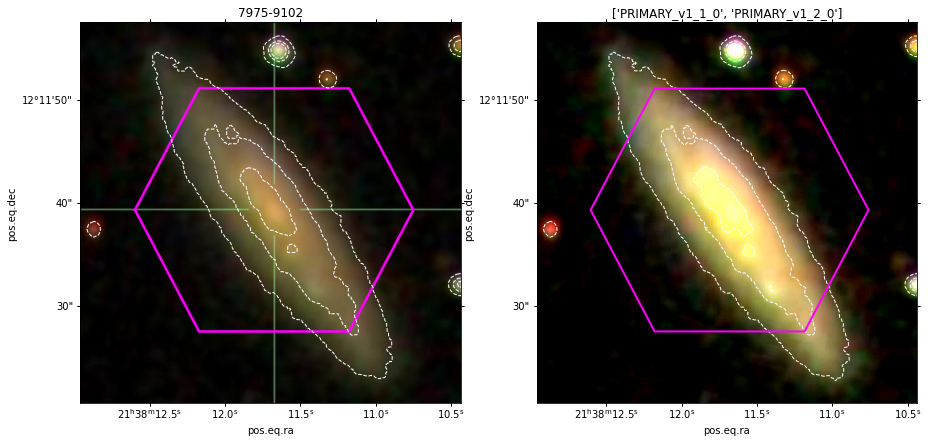

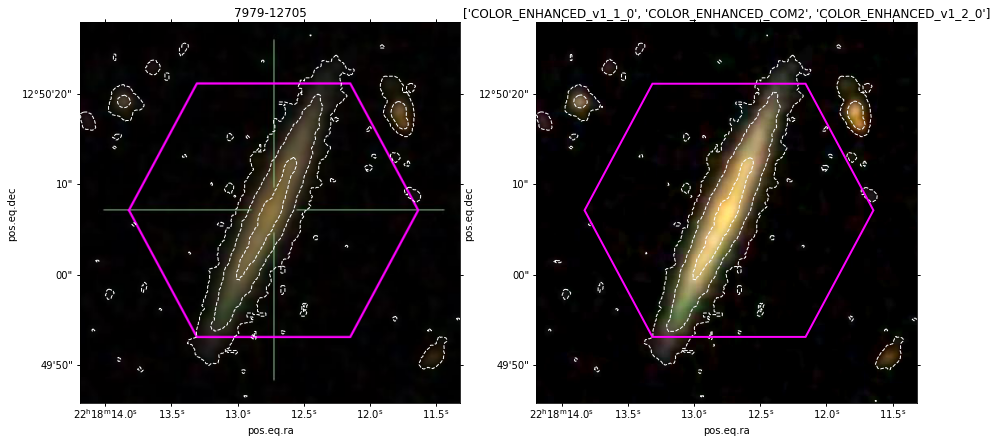

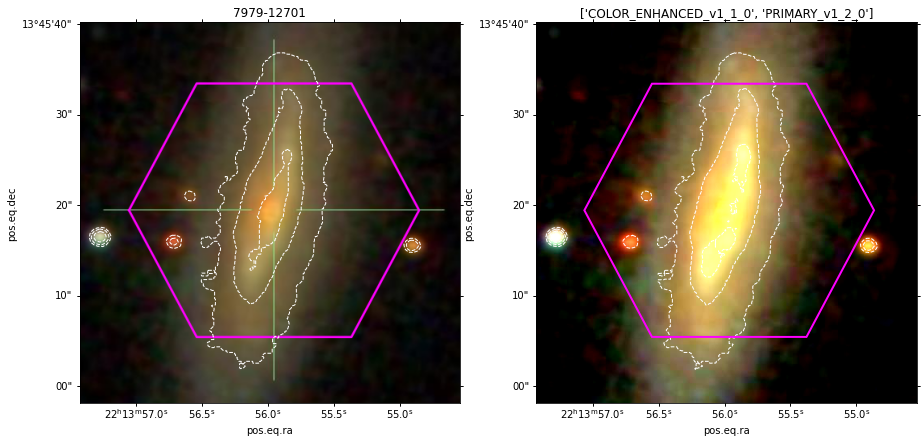

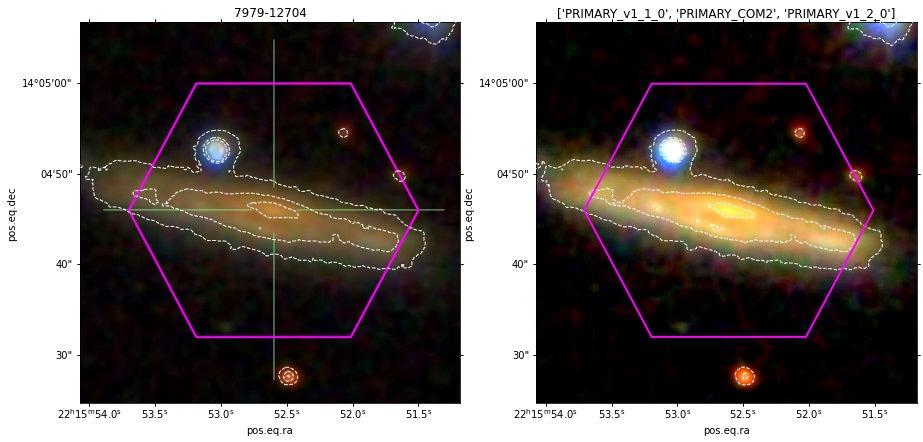

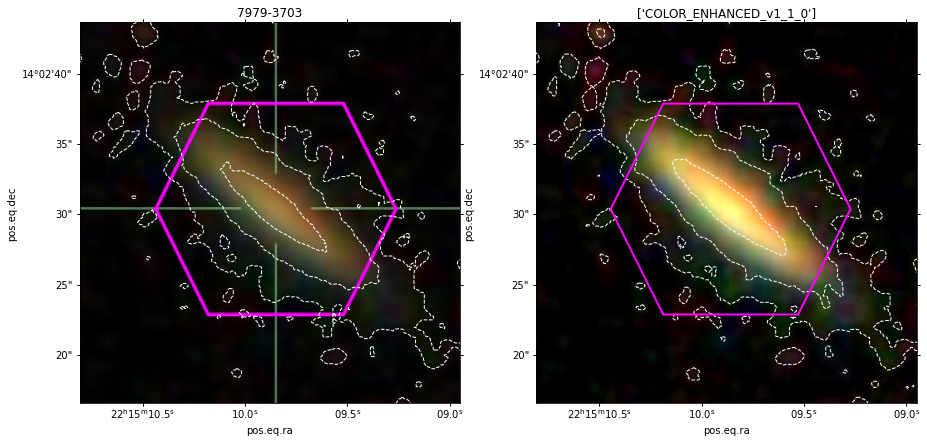

In [183]:
from PIL import ImageFilter
from PIL import ImageEnhance


# filename = 'mpl_11_images.pdf'


with PdfPages(filename) as pdf:
### original cutout with hexagon and sky footprints overlayed 
    for i in range(20):

        plateifu = drp_edge_late['plateifu'][i]
        print('({}) {}'.format(i, plateifu))

        maps = Maps(plateifu=plateifu, bintype='HYB10', drpall=drpDat)
        print(maps.manga_target1.labels)

        ### Spatial properties of the maps 
        wcs = maps.wcs.dropaxis(2)
        spaxel_size = wcs.pixel_scale_matrix[1,1]*3600
        size = (wcs.wcs.crpix[0]-1)*2

        
        im = Image(plateifu, download=False)
        im_data = im.data
        im_wcs = im.wcs

        ## new cutout for image plot contours
        stripOverlay(im)
        hex_bundle = im_wcs.world_to_pixel_values(im.bundle.hexagon)

        
        # get xlimits and ylimits to match maps
        ra_lim, dec_lim = wcs.pixel_to_world_values([0, size-1], [0, size-1])
        [xmin,xmax], [ymin,ymax] = im.wcs.world_to_pixel_values(ra_lim, dec_lim)
        big = scale* 350
        xl = (xmin-big,xmax+big); yl = (ymin-big,ymax+big)



        # ------------------------------------------------- Plotting

        ### making Figure
        fig = plt.figure(constrained_layout=False, figsize=(15,10))
        spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig,  hspace=0.2)
        
        
        # ---- Original image
        ax1 = fig.add_subplot(spec[0,0], projection=im_wcs)
        ax1.imshow(im_data)
        
        # contour
        ct_array, lvls = contourArray(im.data)
        ax1.contour(ct_array, levels=lvls, colors='w', origin='upper', zorder=15, linewidths=1, linestyles='dashed')
        
        # set title
        ax1.set_title(plateifu)
        # set xlimits and ylimits to match maps
        ax1.set(xlim=xl, ylim=yl)
        
        
        # ----
        ### plot image
        ax2 = fig.add_subplot(spec[0,1], projection=im_wcs)
        
        bcontr = ImageEnhance.Contrast(im.data).enhance(2)
        #bright = ImageEnhance.Brightness(bcontr).enhance(.7)
        bsharp = ImageEnhance.Sharpness(bcontr).enhance(.7)
        ax2.imshow(bcontr)
        
        ax2.set_title(str(maps.manga_target1.labels))
        
        # contour
        ct_array, lvls = contourArray(bsharp)
        ax2.contour(ct_array, levels=lvls, origin='upper', zorder=15, linewidths=1, linestyles='dashed', colors='w')
        # set xlimits and ylimits to match maps
        ax2.set(xlim=xl, ylim=yl)
        
        # Add hex
        ax2.add_patch(patch.Polygon(hex_bundle, ec='magenta', fill=False, lw=2, zorder=16))
        
#         pdf.savefig(facecolor=fig.get_facecolor(), edgecolor='none')
#         plt.close()


In [161]:

#ct_array, lvls = contourArray(im.data)
lvls

array([  0., 178.])

[(134.15439550576724, 420.2276224722654),
 (134.1543955048607, 420.2276224728881)]

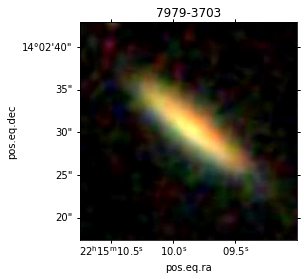

In [28]:
from PIL import ImageEnhance
### plot image
fig = plt.figure()
ax2 = fig.add_subplot(111, projection=im_wcs)

# im_data_smooth = im.data.filter(ImageFilter.BLUR)
im_out = ImageEnhance.Contrast(im.data).enhance(2)
im_arr_smooth = np.array(im_out.convert("L"),'f')
levels= np.quantile(im_arr_smooth, q)

ax2.imshow(im_out)
#ax2.contour(im_arr_smooth, levels=l_smooth, colors='w', origin='upper', zorder=15, linewidths=1, linestyles='dashed')
# set title
ax2.set_title(plateifu)

ax2.set(xlim=(xl[0]-big,xl[1]+big), ylim=(yl[0]-big, yl[1]+big))



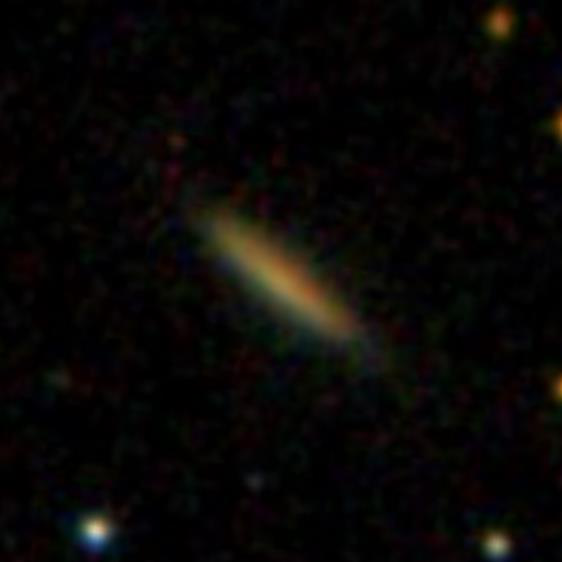

In [67]:
im.data

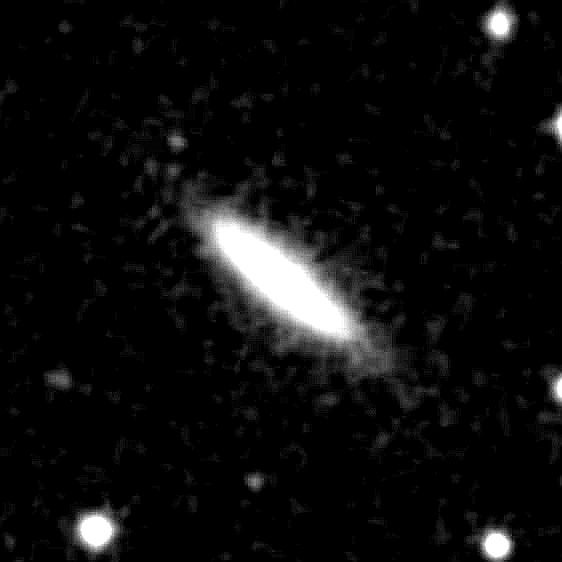

In [66]:
bw_image = im.data.convert("L")
bright_bw = ImageEnhance.Contrast(bw_image).enhance(4)
bsharp = ImageEnhance.Sharpness(bright_bw).enhance(0.1)
# bw_image
#bsharp.show()
ImageEnhance.Sharpness(bright_bw).enhance(4)#.filter(ImageFilter.SMOOTH_MORE)

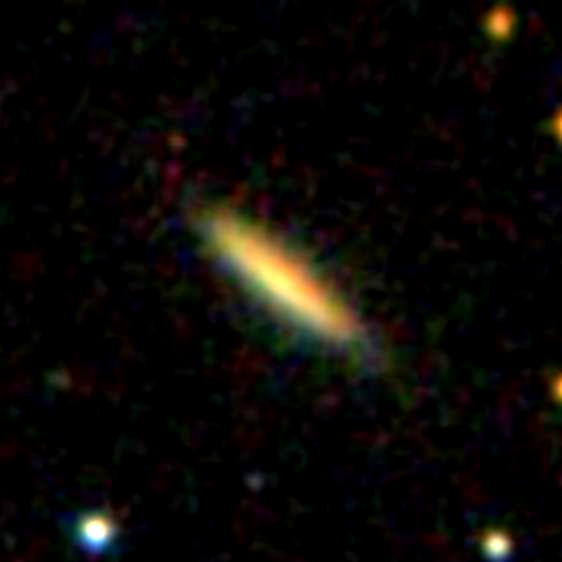

In [43]:
ImageEnhance.Contrast(ImageEnhance.Sharpness(im.data).enhance(0.0)).enhance(2) #.filter(ImageFilter.SMOOTH_MORE).convert("L")

### Saving maps to picke files

In [15]:
# pickle_path = '/Users/rminsley/bates_thesis/pickle_maps/'
# bad = []
# for i, plateifu in enumerate(drp_edge_late['plateifu']):
#     try:
#         print(i)
#         maps = Maps(plateifu=plt_ifu, bintype='HYB10', drpall=drpDat)
#         maps.save(pickle_path + '{}_{}.mpf'.format(i, plateifu))
#         print(plateifu)
#     except:
#         try:
#             print('BAD')
#             time.sleep(5)
            
#             print(i, plateifu)
#             maps = Maps(plateifu=plt_ifu, bintype='HYB10', drpall=drpDat)
#             maps.save(pickle_path + '{}_{}.mpf'.format(i, plateifu))
#         except:
#             bad.append(plt_ifu)
#             print('BAD 2')

# Aligning contours with data 

In [167]:
i = 1

drpDat = drp_edge_late[i]
plateifu = drpDat['plateifu']
ra, dec, z, ba, theta, re_arcsec = drpDat['objra', 'objdec', 'nsa_z', 'nsa_sersic_ba', 'nsa_sersic_phi', 'nsa_sersic_th50']

maps = Maps(plateifu=plateifu, bintype='HYB10', drpall=drpDat)
wcs = maps.wcs.dropaxis(2)

size = int(wcs.wcs.crpix[0]-1) * 2
spaxel_size = wcs.pixel_scale_matrix[1,1]*3600
verts = wcs.array_index_to_world([0, 0, size, size],[0, size, size, 0])
extent = np.array(wcs.array_index_to_world_values([0, size],[0, size])).ravel()

ha = maps.emline_gflux_ha_6564                  # Halpha flux map
haVel = maps.emline_gvel_ha_6564                # Halpha velocity map

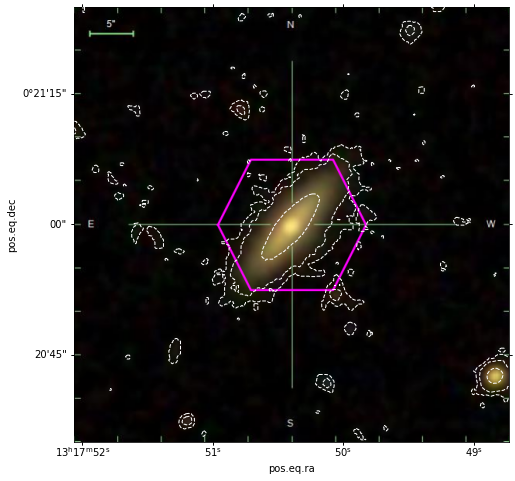

In [233]:
im = Image(plateifu, download=False)
im_data = im.data

h, scale = [float(im.header[key]) for key in ['HEIGHT', 'SCALE']]
im.get_new_cutout(h,h,scale=scale)

im_arr = np.array(im.data.convert("L"),'f')


#######
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=im.wcs)

imshow = ax.imshow(im_data)
levels= np.quantile(im_arr,[.90, .95, .99, 1])
ax.contour(im_arr, levels=levels, colors='w', origin='upper', zorder=15, linewidths=1, linestyles='dashed') 

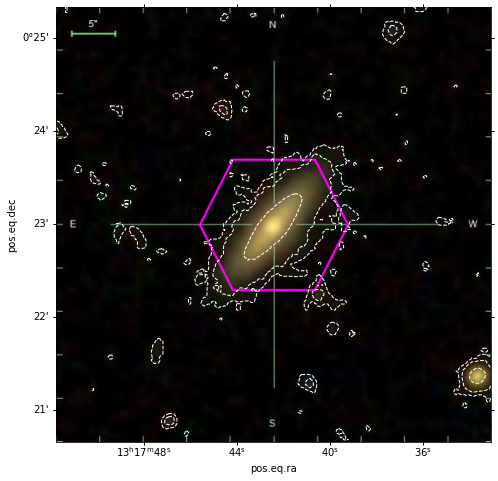

In [266]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=im.wcs)

imshow = ax.imshow(im_data)
levels= np.quantile(im_arr,[.90, .95, .99, 1])
ax.contour(im_arr, levels=levels, colors='w', origin='upper', zorder=15, linewidths=1, linestyles='dashed') 

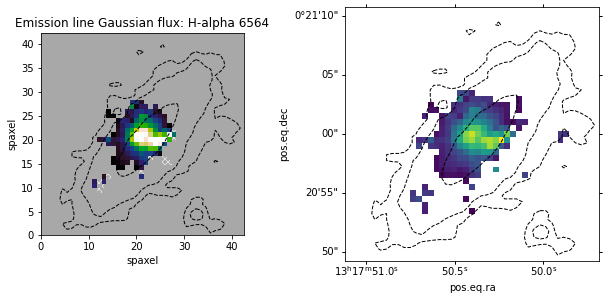

In [268]:
#######
fig = plt.figure(figsize=(10, 20))

ax1 = fig.add_subplot(121)
ha_marv = ha.plot(fig=fig,ax=ax1, return_cb=True, snr_min=3)
ha_marv[2].remove()

#####
ax = fig.add_subplot(122, projection=wcs)

ha_dat = ha.copy().value
ha_dat[ha.snr<3] = np.nan

ax.imshow(ha_dat)


im.get_new_cutout(size*spaxel_size*2, size*spaxel_size*2,scale=spaxel_size)
im_arr2 = np.array(im.data.convert("L"),'f')
xy, _ = im.wcs.world_to_array_index_values(extent[:2], extent[2:])
xy_idx = np.arange(xy[0], xy[1]+1)

ax1.contour(im_arr2[xy_idx, :][:,xy_idx], levels=levels, colors='k', origin='upper', zorder=20, linewidths=1, 
           linestyles='dashed')

ax.contour(im_arr2[xy_idx, :][:,xy_idx], levels=levels, colors='k', origin='upper', zorder=20, linewidths=1, 
           linestyles='dashed')



In [10]:
80 -len(bad)

56

In [48]:
total = len(drp_edge_late)
bad = []
filename = 'mpl_11_FinalClassification.pdf'

with PdfPages(filename) as pdf:
    for i in range(0,20):
        ### getting drp parameters
        drpDat = drp_edge_late[i]

        plateifu = drpDat['plateifu']
        print('({}) {}'.format(i, plateifu))
        ra, dec, z, ba, theta, re_arcsec = drpDat['objra', 'objdec', 'nsa_z', 'nsa_sersic_ba', 'nsa_sersic_phi', 'nsa_sersic_th50']
#         try:
        maps = Maps(plateifu=plateifu, bintype='HYB10', drpall=drpDat)
        # Getting all maps at once 
        ha = maps.emline_gflux_ha_6564                  # Halpha flux map
        haVel = maps.emline_gvel_ha_6564                # Halpha velocity map
        rband_snr = maps.spx_snr                        # R-band signal/noise
        stellar_vel = maps.stellar_vel                  # Stellar velocity
        vel_disp = maps.emline_gsigma_ha_6564           # Velocity Dispersion 


        # Updatine masks for plots
        low_snr = ha.snr < 3                            # Halpha flux s/n cut >3
        ha.mask = ha.mask | low_snr
        haVel.mask = haVel.mask | low_snr


        size= len(ha)
        wcs = maps.wcs.dropaxis(2)
        spaxel_size = wcs.pixel_scale_matrix[1,1]*3600  #in arcseconds
        # Map fov vertices 
        ra_verts, dec_verts = wcs.pixel_to_world_values([0,size-1], [0, size-1])

        # conversion factor -- kpc/arcsec
        arcsec2kpc = (1/cosmo.arcsec_per_kpc_proper(z))


        # ------------------------------ Making asymmetry map

        # create arrays that correspond to x and y coordinates for each spaxel 
        xy_pos = np.arange(size)-np.median(range(size))
        xpos = np.tile(xy_pos,(size,1))
        ypos = xpos.T

        # compute the on-sky x and y coordiates defined by the major axis
        inc = np.arccos(ba)
        trad = np.radians(theta - 90)
        xproj = xpos * np.cos(trad) + ypos * np.sin(trad)
        yproj = xpos * np.sin(trad) * (-1.) + ypos * np.cos(trad)
        zproj = yproj / np.sin(inc) * np.cos(inc)

        # calculate the radius of each pixel in the plane of the disk [units: pixels]
        pixel_radius = np.sqrt(xproj ** 2 + (yproj / ba) ** 2)
        # figure out the conversion between pixel size and kpc
        radkpc = pixel_radius * arcsec2kpc.value * spaxel_size

        # compute values along the x and y axis of the disk and the z axis above the disk
        xproj_kpc = xproj * arcsec2kpc.value * spaxel_size
        yproj_kpc = yproj / ba * arcsec2kpc.value * spaxel_size
        zproj_kpc = zproj / ba * arcsec2kpc.value * spaxel_size

        radkpc_map, xproj_kpc_map, yproj_kpc_map, zproj_kpc_map = np.zeros([4, size, size])
        for j in range(0, size):
            for k in range(0, size):
                radkpc_map[j, k] = radkpc[j, k]
                yproj_kpc_map[j, k] = yproj_kpc[j, k] 
                zproj_kpc_map[j, k] = zproj_kpc[j, k]   


        flip_flux = ha.copy()#copy.deepcopy(ha); 
        flip_vel = haVel.copy()#copy.deepcopy(haVel); 
        major_axis = np.zeros(ha.shape, dtype=bool)     

        for m in range(0, size):
            for n in range(0, size):
                dist = np.sqrt((xproj_kpc - xproj_kpc[m, n]) ** 2 + (yproj_kpc + yproj_kpc[m, n]) ** 2)
                test = (dist == np.min(dist))

                flip_vel.value[m, n] = haVel.value[test]; 
                flip_vel.ivar[m, n] = haVel.ivar[test]; 
                flip_vel.snr[m, n] = haVel.snr[test]
                flip_vel.mask[m,n] = haVel.mask[test]

                flip_flux.value[m, n] = ha.value[test];   
                flip_flux.ivar[m, n] = ha.ivar[test];   
                flip_flux.snr[m, n] = ha.snr[test]

                if (np.ravel(np.where(test == True)) == [m,n]).all():
                    major_axis[m, n] = True


        asym = haVel.copy()#copy.deepcopy(haVel)
        asym.value[:,:] = haVel.value - flip_vel.value
        #asym.ivar = 1. / ((1. / haVel.ivar) + (1. / flip_vel.ivar))
        asym.mask = haVel.mask | flip_vel.mask


        #Getting disk
        re_kpc = (1.5 * re_arcsec) * arcsec2kpc.value # Effective radius = 1.5 * nsa_sersic_th50
        cen = abs(radkpc_map) < (re_kpc)
        perc65 = np.percentile(abs(asym.value.ravel()),65)
        out = (abs(asym.value) < perc65)


        # ------------------------------ Plotting 

        # -- Image
        im = Image(plateifu, download=False)
        im_wcs = im.wcs
        im_data = im.data

        # Get new cutout without hex footprint for contours
        h, scale = [float(im.data.info[val]) for val in ['height','scale']]
        im.get_new_cutout(h,h,scale=scale)
        # Pixel value array of image
        im_arr = np.array(im.data.convert("L"),'f') #np.flip(np.array(im.data.convert("L"),'f'),0)

        # Contour levels
        levels= np.quantile(im_arr,[.90, .95, .99, 1])

        # -- Image data for maps
        im.get_new_cutout(size*spaxel_size*2,size*spaxel_size*2, scale=spaxel_size)
        # IFU Hexagon
        hex_bundle = wcs.world_to_pixel_values(im.bundle.hexagon)
        # Contour data
        xymin, xymax= im.wcs.world_to_array_index_values(ra_verts, dec_verts)[0]
        idx = np.arange(xymin, xymax+1)
        im_arr2 = np.array(im.data.convert("L"),'f')[idx,:][:,idx] #np.flip(np.array(im.data.convert("L"),'f'),0)[idx,:][:,idx]

        # --------------- Making Figure
        fig = plt.figure(constrained_layout=False, figsize=(30,10))
        spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig,  hspace=0.2)


        ### Image
        ax1 = fig.add_subplot(spec[0,0])
        ax1.imshow(np.flip(im_data,(0,1)), origin='lower')
        # Contour -- need to get new cutout otherwise contours the hexigon and other writing
        ax1.contour(np.flip(im_arr,1), levels=levels, colors='w', origin='upper', zorder=15, linewidths=1, linestyles='dashed')   
        # Setting x and y limits
        d = (size/2 * spaxel_size/3600) * np.array([-1,1])
        xlim, ylim = im_wcs.world_to_pixel_values(ra+d, dec+d)
        ax1.set(xlim=xlim, ylim=ylim)
        ax1.set_title(plateifu)                                        


        ### All other maps
        haVel.mask = haVel.mask|major_axis
        mps = [haVel, flip_vel, asym, rband_snr, asym, stellar_vel, maps.emline_gsigma_ha_6564]
        #msks = [haVel.mask|major_axis, flip_vel.mask, asym.mask, maps.spx_snr.mask, asym.mask|out, maps.stellar_vel.mask, maps.emline_gsigma_ha_6564.mask]

        titles = ['Ha vel 6564', 'Ha vel 6564 Flip', 'Asymmetry', 'SNR', 'Asym center_cut', 'Stellar Vel', 'V disp']

        ax2 = fig.add_subplot(spec[0,1])
        ax3 = fig.add_subplot(spec[0,2])
        ax4 = fig.add_subplot(spec[0,3])
        ax5 = fig.add_subplot(spec[1,0])
        ax6 = fig.add_subplot(spec[1,1])
        ax7 = fig.add_subplot(spec[1,2])
        ax8 = fig.add_subplot(spec[1,3])
        axes = [ax2,ax3,ax4,ax5,ax6, ax7, ax8]

        for j in range(len(axes)):
            ax= axes[j]
            mp = mps[j]
    #             mask = msks[j]
            title = titles[j]

            if j==0:
                pl = mp.plot(fig=fig, ax=ax, mask=mp.mask|major_axis, title=title, return_cb=True, sky_coords=False)
                cbrange = (pl[2].vmin, pl[2].vmax)
                pl[2].remove()

            elif j<3:
                pl = mp.plot(fig=fig, ax=ax, mask=mp.mask, title=title, return_cb=True, sky_coords=False, cbrange=cbrange)
                if j<2:
                    pl[2].remove()

            elif j==4:
                pl = mp.plot(fig=fig, ax=ax, mask=mp.mask|cen, title=title, return_cb=True, sky_coords=False)

            else: 
                pl = mp.plot(fig=fig, ax=ax, mask=mp.mask, title=title, return_cb=True, sky_coords=False)

            ax.add_patch(patch.Polygon(hex_bundle, ec='magenta', fill=False, lw=2, zorder=11))
            ax.contour(im_arr2, levels=levels, colors='w',zorder=15, linewidths=1, linestyles='dashed', origin='image', extent=[0, size-1, 0, size-1])

        pdf.savefig(facecolor=fig.get_facecolor(), edgecolor='none')
        plt.close()
#         except:
#             bad.append(plateifu)
# #             time.sleep(5)
#             print('BAD')
    

(0) 12514-3704


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(1) 10843-12704


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(2) 11866-9101


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(3) 10843-12703


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(4) 12071-9101


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(5) 12696-9102


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(6) 8078-12704


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(7) 11836-1901


[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


(8) 12685-12703


MarvinError: found a problem when getting the map: a bytes-like object is required, not 'str'.
You can submit this error to Marvin GitHub Issues (https://github.com/sdss/marvin/issues/new).
Fill out a subject and some text describing the error that just occurred.
If able, copy and paste the full traceback information into the issue as well.

In [168]:
cube = Cube(plateifu=plt_ifu, release='MPL-11', drpall=drpDat)
size= cube.header['NAXIS2']
wcs = cube.wcs.dropaxis(2)

mcube = ModelCube(plateifu=plt_ifu, release='MPL-11', drpall=drpDat)
#mcube.header
emline = mcube.datamodel.emline_fit
help(emline)
#emline#__dict__

Help on Model in module marvin.utils.datamodel.dap.base object:

class Model(builtins.object)
 |  Model(name, extension_name, extension_wave=None, extension_ivar=None, extension_mask=None, channels=[], unit=Unit(dimensionless), scale=1, formats={}, parent=None, binid=None, description='', db_table='modelspaxel', pixmask_flag='MANGA_DAPSPECMASK')
 |  
 |  Represents a extension in the DAP logcube file.
 |  
 |  Parameters:
 |      name (str):
 |          The model name. This is the internal name that Marvin will use for
 |          this model. It is different from the ``extension_name`` parameter,
 |          which must be identical to the extension name of the model.
 |      extension_name (str):
 |          The FITS extension containing this model.
 |      extension_wave (str):
 |          The FITS extension containing the wavelength for this model.
 |      extension_ivar (str or None):
 |          The extension that contains the inverse variance associated with
 |          this model

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4f42c7220>)

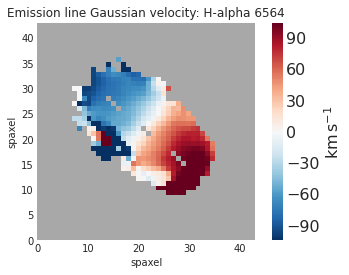

In [36]:
for i in range(0,20):
    ### getting drp parameters
    drpDat = drp_edge_late[i]

    plt_ifu = drpDat['plateifu']
    ra, dec, z, ba, theta, re_arcsec = drpDat['objra', 'objdec', 'nsa_z', 'nsa_sersic_ba', 'nsa_sersic_phi', 'nsa_sersic_th50']
    print('({}) {}'.format(i, plt_ifu))
    
    
    # Getting cube from api
    cube = Cube(plateifu=plt_ifu, release='MPL-11', drpall=drpDat)
    
    wcs = cube.wcs.dropaxis(2)           # ****** WCS ********
    
    size = int(cube.header['NAXIS2'])    # ****** map size ********
    
    
    # Get map object from api
    maps = cube.getMaps()
    
    
#         try:
    maps = Maps(plateifu=plt_ifu, bintype='HYB10', drpall=drpDat)
    # Getting all maps at once 
    ha = maps.emline_gflux_ha_6564                  # Halpha flux map
    haVel = maps.emline_gvel_ha_6564                # Halpha velocity map
    rband_snr = maps.spx_snr                        # R-band signal/noise
    stellar_vel = maps.stellar_vel                  # Stellar velocity
    vel_disp = maps.emline_gsigma_ha_6564           # Velocity Dispersion 

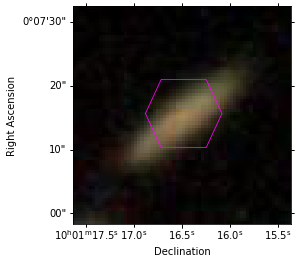

In [17]:
ax = im.plot(with_axes=True);
im.overlay_hexagon(ax)
#im.overlay_skies(ax)

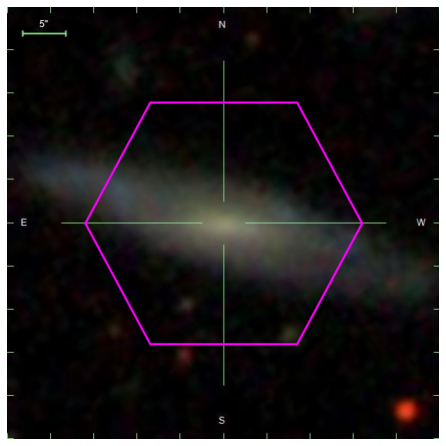

In [24]:
images = Image(plateifu=plt_ifu)
images.plot()

In [109]:
xv, yv = wcs.array_index_to_world_values([0, size], [0,size])
print(wcs.array_index_to_world_values([0, size], [0,size]))
im.wcs.world_to_array_index_values(xv,yv)
#xymin, xymax= im.wcs.world_to_array_index_values(ra_verts, dec_verts)[0]
#xymax
im.wcs.array_index_to_world_values([0,size],[0,size])

(array([316.54524075, 316.53789917]), array([10.34180887, 10.34903109]))


(array([316.54877023, 316.54142882]), array([10.33833658, 10.34555889]))

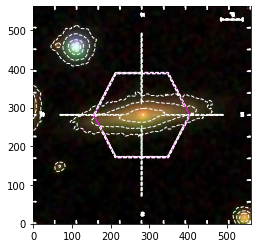

In [26]:
i=250
plt_ifu = drp_edge_late['plateifu'][i]

# -- Image
im = Image(plt_ifu, download=True)
im_wcs = im.wcs
im_data = im.data

#im.plot()
data = np.array(im.data)
d = np.flip(data, (0,1))
plt.imshow(d, origin='lower')

im_arr = np.flip(np.array(im.data.convert("L"),'f'),1)
plt.contour(im_arr, levels=levels, colors='w', zorder=15, linewidths=1, 
            linestyles='dashed', origin='upper') 

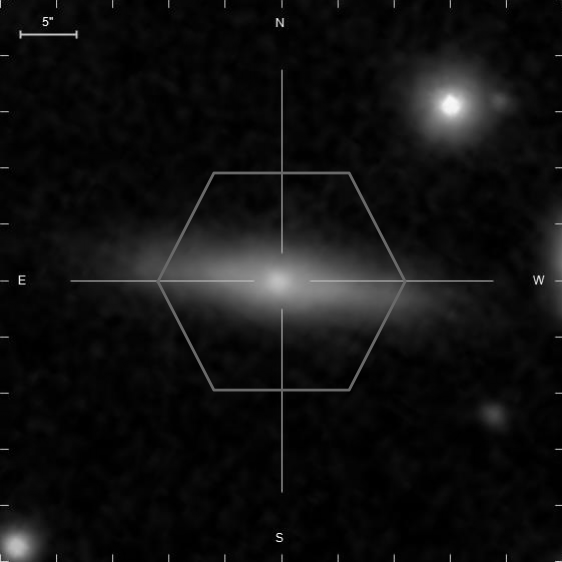

In [31]:
im.data.convert("L")

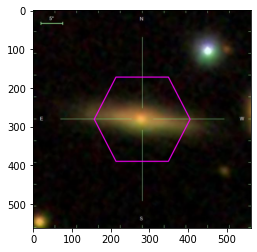

In [175]:
plt.imshow(data, origin='upper')

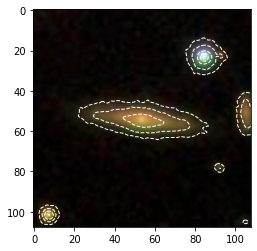

In [40]:
# Get new cutout without hex footprint for contours
h, scale = [float(im.data.info[val]) for val in ['height','scale']]
im.get_new_cutout(h,h,scale=scale)

plt.imshow(im.data, origin='upper')

# Pixel value array of image
im_arr = np.array(im.data.convert("L"),'f')
plt.contour(im_arr, levels=levels, colors='w', zorder=15, linewidths=1, 
            linestyles='dashed', origin='lower') 

In [41]:
maps = Maps(plateifu=plt_ifu, bintype='HYB10')
snr = maps.spx_snr                  # Halpha flux map

size = len(snr)
im.get_new_cutout(size*spaxel_size*2,size*spaxel_size*2,scale=spaxel_size)

wcs = maps.wcs.dropaxis(2)

[26 80]


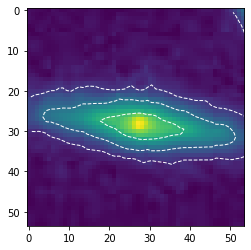

In [42]:
ra_v, dec_v = wcs.array_index_to_world_values([0,size],[0,size])
idx_vals, _ = im.wcs.world_to_array_index_values(ra_v, dec_v)
print(idx_vals)

im_pix = np.array(im.data.convert("L"),'f')
plt.imshow(im_pix[26:80, :][:,26:80], origin='upper')
plt.contour(im_pix[26:80, :][:,26:80], levels=levels, colors='w', zorder=15, linewidths=1, 
            linestyles='dashed', origin='lower') 

In [43]:
im.wcs.world_to_array_index_values(ra_v, dec_v)

(array([26, 80]), array([26, 80]))

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


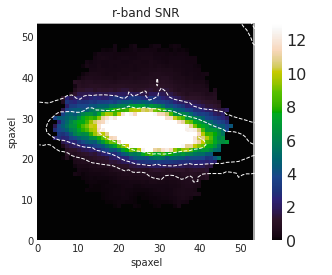

In [157]:
fig, ax = snr.plot()
ax.contour(im_pix[26:80, :][:,26:80], levels=levels, colors='w', zorder=15, linewidths=1, 
            linestyles='dashed', origin='image') 